# Assignment 3

Deadline: 09.04.2025 12:00 CET

<Add your name, student-id and emal address>

In [2]:
# Standard library imports
import os
import sys
import types

# Third party imports
import numpy as np
import pandas as pd

# Add the project root directory to Python path
# Load environment variables from .env file
from dotenv import load_dotenv
load_dotenv()
src_path = os.getenv('PROJECT_SOURCE_DIR')
#print(src_path)
sys.path.append(src_path)

# Local modules imports
from helper_functions import load_data_msci
from estimation.covariance import Covariance
from estimation.expected_return import ExpectedReturn
from optimization.optimization import MeanVariance
from backtesting.backtest_item_builder_classes import (
    SelectionItemBuilder,
    OptimizationItemBuilder,
)
from backtesting.backtest_item_builder_functions import (
    bibfn_selection_data_random,
    bibfn_return_series,
    bibfn_budget_constraint,
    bibfn_box_constraints,
)
from backtesting.portfolio import floating_weights
from backtesting.backtest_service import BacktestService
from backtesting.backtest import Backtest

### Data load

In [3]:
N = 24
data = load_data_msci(path = '../data/', n = N)  #<Change the path if needed>

### Prepare backtest service

In [4]:
# Define rebalancing dates
n_days = 21 * 3
start_date = '2010-01-01'
dates = data['return_series'].index
rebdates = dates[dates > start_date][::n_days].strftime('%Y-%m-%d').tolist()

# Define the selection item builders.
selection_item_builders = {
    'data': SelectionItemBuilder(
        bibfn = bibfn_selection_data_random,
        k = 10,
        seed = 42,
    ),
}

# Define the optimization item builders.
optimization_item_builders = {
    'return_series': OptimizationItemBuilder(
        bibfn = bibfn_return_series,
        width = 365 * 3,
    ),
    'budget_constraint': OptimizationItemBuilder(
        bibfn = bibfn_budget_constraint,
        budget = 1,
    ),
    'box_constraints': OptimizationItemBuilder(
        bibfn = bibfn_box_constraints,
        upper = 0.5,
    ),
}

# Initialize the backtest service
bs = BacktestService(
    data = data,
    selection_item_builders = selection_item_builders,
    optimization_item_builders = optimization_item_builders,
    optimization = MeanVariance(
        covariance = Covariance(method = 'pearson'),
        expected_return = ExpectedReturn(method = 'geometric'),
        risk_aversion = 1,
        solver_name = 'cvxopt',
    ),
    rebdates = rebdates,
)

### Run the backtest

In [5]:
# Instantiate the backtest object and run the backtest
bt_mv = Backtest()

# Run the backtest
bt_mv.run(bs = bs)

Rebalancing date: 2010-01-04
Rebalancing date: 2010-04-01
Rebalancing date: 2010-06-29
Rebalancing date: 2010-09-24
Rebalancing date: 2010-12-22
Rebalancing date: 2011-03-21
Rebalancing date: 2011-06-16
Rebalancing date: 2011-09-13
Rebalancing date: 2011-12-09
Rebalancing date: 2012-03-07
Rebalancing date: 2012-06-04
Rebalancing date: 2012-08-30
Rebalancing date: 2012-11-27
Rebalancing date: 2013-02-22
Rebalancing date: 2013-05-22
Rebalancing date: 2013-08-19
Rebalancing date: 2013-11-14
Rebalancing date: 2014-02-11
Rebalancing date: 2014-05-09
Rebalancing date: 2014-08-06
Rebalancing date: 2014-11-03
Rebalancing date: 2015-01-29
Rebalancing date: 2015-04-28
Rebalancing date: 2015-07-24
Rebalancing date: 2015-10-21
Rebalancing date: 2016-01-18
Rebalancing date: 2016-04-14
Rebalancing date: 2016-07-12
Rebalancing date: 2016-10-07
Rebalancing date: 2017-01-04
Rebalancing date: 2017-04-03
Rebalancing date: 2017-06-29
Rebalancing date: 2017-09-26
Rebalancing date: 2017-12-22
Rebalancing da

## 1. Turnover

**(6 points)**

Complete the function `turnover`.

In [9]:

def turnover(self, return_series: pd.DataFrame, rescale: bool=True):

    dates = self.get_rebalancing_dates()
    turnover_data = {}
    turnover_data[dates[0]] = float(1)

    for rebalancing_date in dates[1:]:

        previous_portfolio = self.get_previous_portfolio(rebalancing_date)
        current_portfolio = self.get_portfolio(rebalancing_date)

        # Get the union of the ids of the weights in both portfolios (previous and current)
        prev_ids = set(previous_portfolio.weights.keys())
        current_ids = set(current_portfolio.weights.keys())
        all_ids = list(prev_ids.union(current_ids))
        #print(all_ids)

        # Extend the weights of the previous portfolio to the the union of ids in both portfolios by adding zeros
        prev_weights_extended = pd.Series(
            index=all_ids,
            data=[previous_portfolio.weights.get(id, 0) for id in all_ids]
        )
        #print(prev_weights_extended)
        
        # Float the weights of the previous portfolio according to the price drifts in the market
        # until the current rebalancing date
        # Hint: use function floating_weights from module portfolio.py
        previous_date = dates[dates.index(rebalancing_date) - 1]  # Get previous rebalancing date
        floated_weights = floating_weights(
            X=return_series,
            w=prev_weights_extended,
            start_date=previous_date,
            end_date=rebalancing_date,
            rescale=rescale
        )
        #print(floated_weights)

        # Extract the weights of the current portfolio
        current_weights = pd.Series(
            index=all_ids,
            data=[current_portfolio.weights.get(id, 0) for id in all_ids]
        )

        # Calculate the turnover
        weights_diff = np.abs(current_weights.values - floated_weights.values)
        turnover_data[rebalancing_date] = float(np.sum(weights_diff))

    return pd.Series(turnover_data, dtype=float)


2: Simulation

(6 points)

Complete the function `simulate`.

In [10]:
def simulate(self,
                return_series: pd.DataFrame,
                fc: float = 0,
                vc: float = 0,
                n_days_per_year: int = 252) -> pd.Series:

    rebdates = self.get_rebalancing_dates()
    ret_list = []
    for rebdate in rebdates:
        next_rebdate = (
            rebdates[rebdates.index(rebdate) + 1]
            if rebdate < rebdates[-1]
            else return_series.index[-1]
        )

        portfolio = self.get_portfolio(rebdate)
        w_float = portfolio.float_weights(
            return_series=return_series,
            end_date=next_rebdate,
            rescale=False # Notice that rescale is hardcoded to False.
        )
        level = w_float.sum(axis=1)
        ret_tmp = level.pct_change(1)
        ret_list.append(ret_tmp)

    portf_ret = pd.concat(ret_list).dropna()

    if vc != 0:
        # Calculate turnover
        to = self.turnover(return_series=return_series, rescale=False)
        
        # Calculate variable cost (vc) as a fraction of turnover and
        # subtract the variable cost from the returns at each rebalancing date
        for rebdate in rebdates:
            if rebdate in to.index and rebdate in portf_ret.index:
                # Subtract the variable cost on the rebalancing date
                # Variable cost = turnover * variable cost rate
                portf_ret.loc[rebdate] -= to.loc[rebdate] * vc

    if fc != 0:
        # Calculate daily fixed cost based on the annual fixed cost (fc),
        # the number of days between two rebalancings and the number of days per year
        daily_fc = fc / n_days_per_year
         # Subtract the daily fixed cost from the daily returns
        portf_ret = portf_ret.sub(daily_fc)  # Vectorized subtraction

    return portf_ret

Overwrite the turnover and the simulation methods of the current strategy object.

In [12]:
# Overwrite the turnover method of the strategy object
bt_mv.strategy.turnover = types.MethodType(turnover, bt_mv.strategy)

# Overwrite the simulate method of the strategy object
bt_mv.strategy.simulate = types.MethodType(simulate, bt_mv.strategy)

Calculate and plot the turnover.

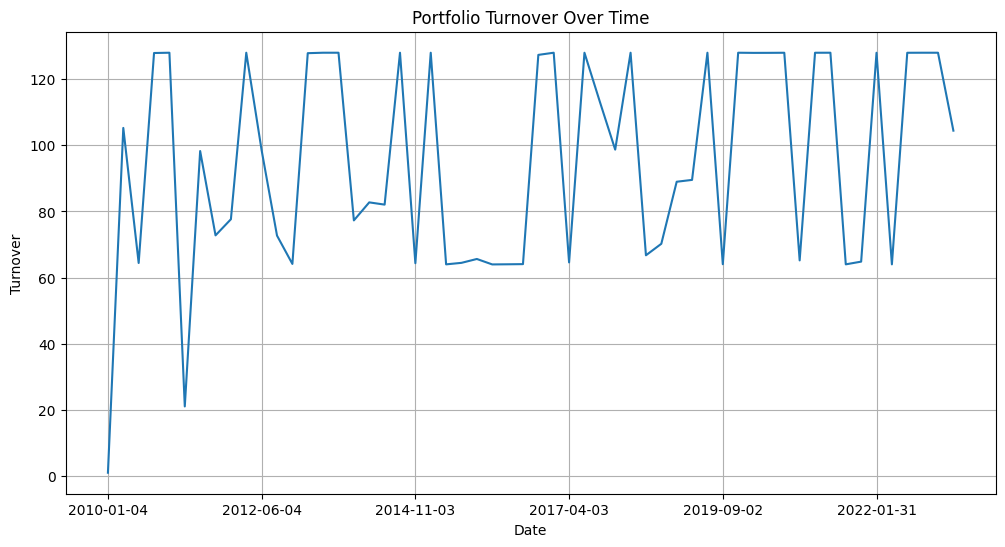

In [13]:
res = bt_mv.strategy.turnover(
    return_series = data['return_series'],
    rescale = True,
).plot(
    title='Portfolio Turnover Over Time',
    figsize=(12, 6),
    grid=True,
    ylabel='Turnover',
    xlabel='Date'
)

#print(res)
#print("Data type:", res.dtype)

#bt_mv.strategy.turnover(
#    return_series = data['return_series'],
#    rescale = True,
#).plot(title = 'Turnover', figsize = (10, 5))


Simulate with different cost assumptions.

In [14]:
return_series = bs.data['return_series']

sim_mv_gross = bt_mv.strategy.simulate(return_series=return_series, fc=0, vc=0)
sim_mv_net_of_fc = bt_mv.strategy.simulate(return_series=return_series, fc=0.01, vc=0)
sim_mv_net_of_vc = bt_mv.strategy.simulate(return_series=return_series, fc=0, vc=0.002)
sim_mv_net = bt_mv.strategy.simulate(return_series=return_series, fc=0.01, vc=0.002)


Plot the cumulative returns.

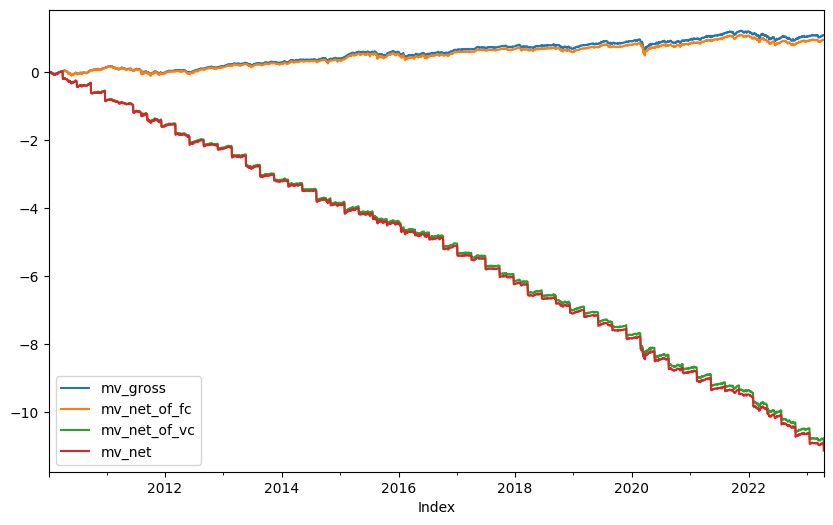

In [16]:
sim = pd.concat({
    'mv_gross': sim_mv_gross,
    'mv_net_of_fc': sim_mv_net_of_fc,
    'mv_net_of_vc': sim_mv_net_of_vc,
    'mv_net': sim_mv_net,
}, axis = 1).dropna()


np.log((1 + sim)).cumsum().plot(figsize = (10, 6));

3: Descriptive Statistics

(3 points)

Generate a table with descriptive statistics of the simulations. Include the following statistics:
- cumulative return (i.e., the return over the entire simulation period)
- annualized average returns
- annualized volatility
- sharpe ratio
- maximum drawdown

In [17]:
import empyrical as ep

# Compute individual performance metrics for each simulated strategy using empyrical
annual_return = {}
cumulative_returns = {}
annual_volatility = {}
sharpe_ratio = {}
max_drawdown = {}

for column in sim.columns:
    print(f'Performance metrics for {column}')
    annual_return[column] = ep.annual_return(sim[column])
    cumulative_returns[column] = ep.cum_returns(sim[column]).tail(1).values[0]
    annual_volatility[column] = ep.annual_volatility(sim[column])
    sharpe_ratio[column] = ep.sharpe_ratio(sim[column])
    max_drawdown[column] = ep.max_drawdown(sim[column])

# Create DataFrames for each metric
annual_returns = pd.DataFrame(annual_return, index=['Annual Return'])
cumret = pd.DataFrame(cumulative_returns, index=['Cumulative Return'])
annual_volatility = pd.DataFrame(annual_volatility, index=['Annual Volatility'])
sharpe = pd.DataFrame(sharpe_ratio, index=['Sharpe Ratio'])
mdd = pd.DataFrame(max_drawdown, index=['Max Drawdown'])

# Combine all metrics into a single DataFrame
performance_metrics = pd.concat([annual_returns, cumret, annual_volatility, sharpe, mdd])

# Display the performance metrics
performance_metrics

Performance metrics for mv_gross
Performance metrics for mv_net_of_fc
Performance metrics for mv_net_of_vc
Performance metrics for mv_net


,mv_gross,mv_net_of_fc,mv_net_of_vc,mv_net
Annual Return,0.083095,0.072321,-0.550866,-0.555351
Cumulative Return,1.997802,1.612675,-0.999983,-0.999986
Annual Volatility,0.147436,0.147436,0.431202,0.431202
Sharpe Ratio,0.615308,0.547482,-1.602678,-1.625869
Max Drawdown,-0.307494,-0.308136,-0.999984,-0.999986
